In [12]:
import numpy as np
import math
from numba import njit
import warnings
warnings.filterwarnings("ignore")
from viz import plot_samplers

# Laplace prior + Gaussian likelihood
# Prior: p(x) ∝ exp(-λ||x||_1) where ||x||_1 = |x1| + |x2|
# Likelihood: p(y|x) ∝ exp(-||y - x||²/(2σ²))
# Posterior: p(x|y) ∝ exp(-U(x)) where U(x) = λ||x||_1 + ||y - x||²/(2σ²)

# Parameters
lam = 5.0  # Laplace prior scale parameter
sigma2 = 1.  # Gaussian likelihood variance
y_obs = np.array([2.0, 3.0])  # Observed data

@njit
def grad_U(z):
    """
    Gradient of potential U(x) = λ||x||_1 + ||y - x||²/(2σ²)
    
    The Laplace prior creates a non-smooth point at origin.
    Gradient of |x_i| is sign(x_i), undefined at 0 (we use 0 there).
    """
    x1, x2 = z
    
    # Gradient from Laplace prior: λ * sign(x)
    # Use np.sign which is numba-compatible
    grad_laplace_x1 = lam * np.sign(x1)
    grad_laplace_x2 = lam * np.sign(x2)
    
    # Gradient from Gaussian likelihood: (x - y) / σ²
    grad_likelihood_x1 = (x1 - y_obs[0]) / sigma2
    grad_likelihood_x2 = (x2 - y_obs[1]) / sigma2
    
    # Total gradient
    grad_x1 = grad_laplace_x1 + grad_likelihood_x1
    grad_x2 = grad_laplace_x2 + grad_likelihood_x2
    
    return np.array([grad_x1, grad_x2])

@njit
def log_p(x1, x2):
    """
    Log posterior (up to constant):
    log p(x|y) = -λ||x||_1 - ||y - x||²/(2σ²)
    """
    # Laplace prior contribution
    log_prior = -lam * (np.abs(x1) + np.abs(x2))
    
    # Gaussian likelihood contribution
    diff1 = x1 - y_obs[0]
    diff2 = x2 - y_obs[1]
    log_likelihood = -(diff1**2 + diff2**2) / (2 * sigma2)
    
    return log_prior + log_likelihood

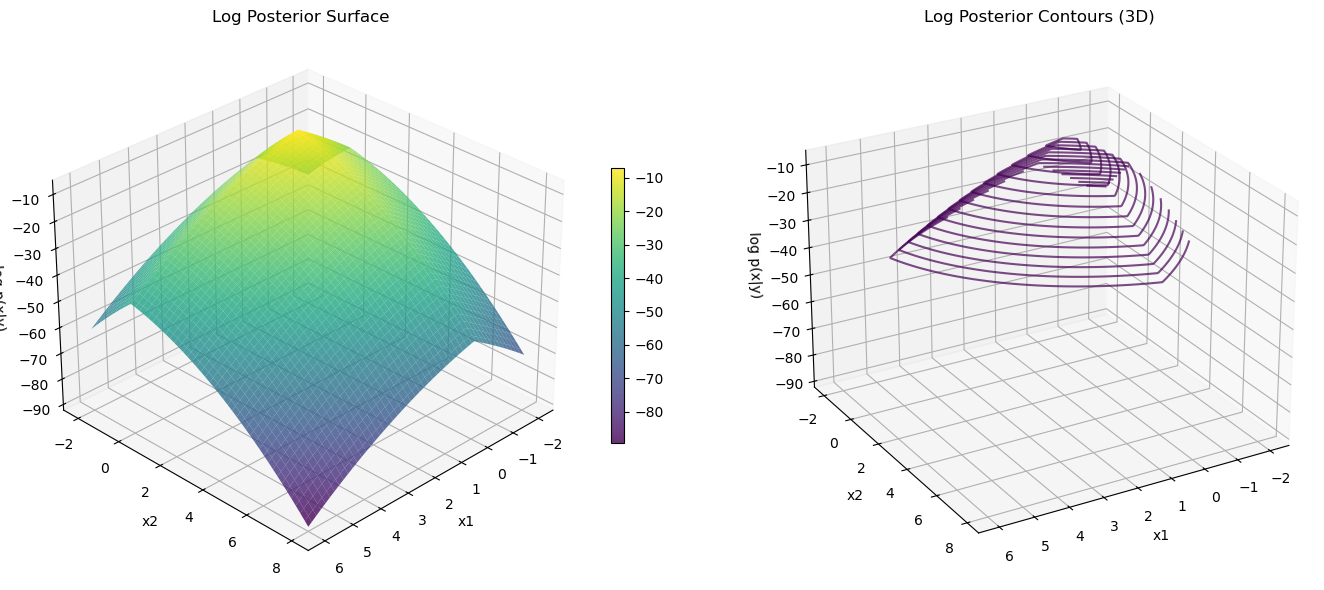

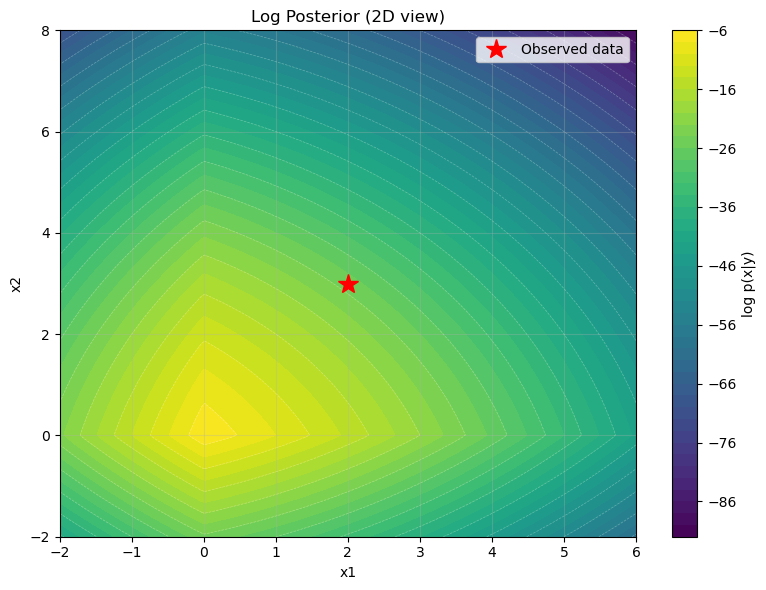

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create grid
xs = np.linspace(-2, 6, 200)
ys = np.linspace(-2, 8, 200)
X, Y = np.meshgrid(xs, ys)

# Compute log probability
Z = log_p(X, Y)

# Create 3D plot
fig = plt.figure(figsize=(14, 6))

# Surface plot
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, 
                         linewidth=0, antialiased=True)
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_zlabel('log p(x|y)')
ax1.set_title('Log Posterior Surface')
ax1.view_init(elev=30, azim=45)
fig.colorbar(surf, ax=ax1, shrink=0.5)

# Contour plot with 3D view
ax2 = fig.add_subplot(122, projection='3d')
# Plot multiple contour levels at different heights
levels_3d = np.linspace(Z.max() - 30, Z.max(), 15)
for i, level in enumerate(levels_3d):
    ax2.contour(X, Y, Z, levels=[level], zdir='z', offset=level, 
                cmap='viridis', alpha=0.7)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_zlabel('log p(x|y)')
ax2.set_title('Log Posterior Contours (3D)')
ax2.view_init(elev=25, azim=60)

plt.tight_layout()
plt.show()

# Also create a simple 2D contour for reference
fig2, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, Z, levels=50, cmap='viridis')
ax.contour(X, Y, Z, levels=20, colors='white', alpha=0.3, linewidths=0.5)
ax.plot(y_obs[0], y_obs[1], 'r*', markersize=15, label='Observed data')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Log Posterior (2D view)')
ax.legend()
ax.grid(True, alpha=0.3)
fig2.colorbar(contour, ax=ax, label='log p(x|y)')
plt.tight_layout()
plt.show()

---- Finished running BAOAB ----
---- Finished running ZBAOABZ ----


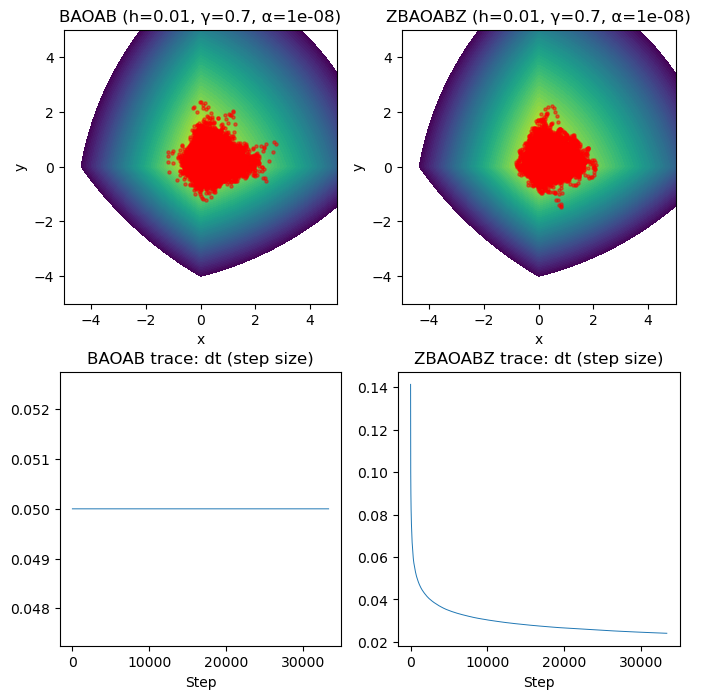

In [17]:
###############################################################################################
# Grid for visualization
xs = np.linspace(-5, 10, 300)
ys = np.linspace(-5, 10, 300)
X, Y = np.meshgrid(xs, ys)
LOGZ = log_p(X, Y)
vmax, vmin = LOGZ.max(), LOGZ.max() - 40
levels = np.linspace(vmin, vmax, 60)

# Sampler parameters
m, M, r, s = 0.5, 50, 0.25, 2
b = 5  # BAOAB stepsize multiplier
burnin = int(1e1)
nsteps = int(1e5)

plot_samplers(
    alpha=1e-8,
    h=0.01,
    gamma=0.7,
    beta=1.,
    grad_U=grad_U,
    X=X,
    Y=Y,
    LOGZ=LOGZ,
    levels=levels,
    m=m,
    M=M,
    r=r,
    s=s,
    b=b,
    burnin=burnin,
    nsteps=nsteps,
    record_trace=True,
    plot_stride=3
)